In [102]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.datasets import load_iris

from sklearn.cluster import KMeans

import matplotlib.cm as cm

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, \
                            silhouette_score, silhouette_samples

from sklearn.manifold import TSNE

import warnings
from sklearn.exceptions import ConvergenceWarning

# Корисні функції

In [2]:
def plot_silhoettes(range_n_clusters : list, X : pd.DataFrame, col_1 : str, col_2 : str):
    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # 1-й підграфік - це графік силуетів. 
        # (N_clusters + 1) * 10 призначено для вставки пустого простору між графіками силуетів окремих кластерів, щоб чітко їх розмежувати.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Ініціюємо кластеризатор
        clusterer = KMeans(n_clusters = n_clusters, random_state = 10, n_init = 'auto')
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("Для n_clusters =", n_clusters,
            "Середнє значення silhouette_score становить:", silhouette_avg)

        # Розраховуємо метрику силуету для кожного екземпляра в наборі даних
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Агрегація оцінок силуетів для зразків, що належать кластеру i, і їх сортування
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Позначимо силуетні області номерами кластерів посередині.
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Обчислимо нове значення y_lower для наступного графіка
            y_lower = y_upper + 10

        ax1.set_title("Графік силуетів для різних кластерів.")
        ax1.set_xlabel("Значення коефіцієнта силуету")
        ax1.set_ylabel("Мітка кластера")

        # Вертикальна лінія - середнє значення силуету для всіх значень.
        ax1.axvline(x = silhouette_avg, color = "red", linestyle = "--")

        ax1.set_yticks([])  # Прибрати мітки на осі y
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2-й підграфік, що показує фактично сформовані кластери
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[col_1], X[col_2], marker = ".", s = 30, lw = 0, alpha = 0.7, c = colors, edgecolor = "k"
        )

        # Центри кластерів
        centers = clusterer.cluster_centers_
        # Білі кружечки в центрі кластерів
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker = "o",
            c = "white",
            alpha = 1,
            s = 200,
            edgecolor = "k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker = "$%d$" % i, alpha = 1, s = 50, edgecolor = "k")

        ax2.set_title("Візуалізація кластеризованих даних.")
        ax2.set_xlabel("Простір ознак для 1-ї ознаки")
        ax2.set_ylabel("Простір ознак для 2-ї ознаки")

        plt.suptitle(
            "Аналіз силуетів для кластеризації KMeans на зразкових даних з n_clusters = %d"
            % n_clusters,
            fontsize = 14,
            fontweight = "bold",
        )

    plt.show()

In [3]:
def get_f1_score(target, preds, name=''):
    f1_score_ = f1_score(target, preds, average = 'weighted')
    
    print(f"F1 score {name}: {f1_score_:.2f}%")

In [4]:
def predict_and_plot(y_train, y_test, y_train_pred, y_test_pred):   
    plt.figure(figsize=(10, 3))
     
    accuracy_train = accuracy_score(y_train, y_train_pred)
    print("Training accuracy: {:.2f}%".format(accuracy_train * 100))
    get_f1_score(y_train, y_train_pred, 'Training')

    accuracy_test = accuracy_score(y_test, y_test_pred)
    print("Test accuracy: {:.2f}%".format(accuracy_test * 100))
    get_f1_score(y_test, y_test_pred, 'Test')

    plt.subplot(1, 2, 1)
    cf_train = confusion_matrix(y_train, y_train_pred, normalize='true')
    sns.heatmap(cf_train, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Training Confusion Matrix');

    plt.subplot(1, 2, 2)
    cf_train = confusion_matrix(y_test, y_test_pred, normalize='true')
    sns.heatmap(cf_train, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Test Confusion Matrix');

In [5]:
def get_report(targets_train, preds_train, targets_test, preds_test):
    print('Training')
    print(classification_report(targets_train, preds_train, digits = 4))
    print('\nTest')
    print(classification_report(targets_test, preds_test, digits = 4))

# Завдання 1

In [4]:
# Завантаження датасету Ірис

df_iris_sklearn = load_iris()

X = pd.DataFrame(data = df_iris_sklearn.data,
                       columns = df_iris_sklearn.feature_names)

y = df_iris_sklearn.target

In [5]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [6]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## KMeans

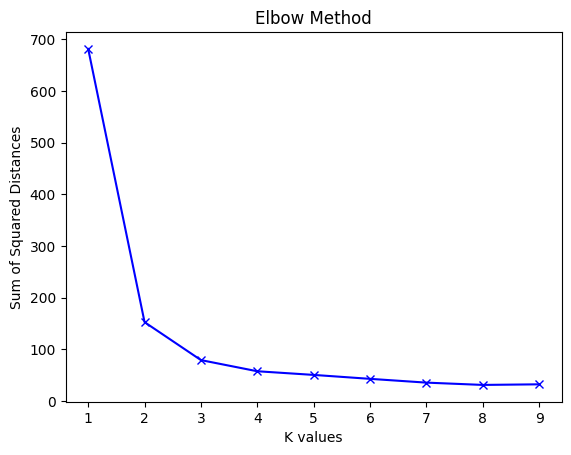

In [7]:
# реалізація методу ліктя

K = range(1,10)
sum_of_squared_distances = []

for k in K:
    model = KMeans(n_clusters = k, n_init = 'auto').fit(X)
    sum_of_squared_distances.append(model.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('K values')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()

Бачимо, що кількість кластерів може дорівнювати або 2 або 3.

In [8]:
kmeans_2 = KMeans(n_clusters = 2, n_init = 'auto')
kmeans_2.fit(X)

labels_2 = kmeans_2.predict(X)
print(labels_2)

s = silhouette_score(X, labels_2, metric = 'euclidean')
print(f'Silhouette Coefficient for the data Dataset Clusters for k = 2: {s:.2f}')

kmeans_3 = KMeans(n_clusters = 3, n_init = 'auto')
kmeans_3.fit(X)

labels_3 = kmeans_3.predict(X)
print('\n', labels_3)

s = silhouette_score(X, labels_3, metric = 'euclidean')
print(f'Silhouette Coefficient for the data Dataset Clusters for k = 3: {s:.2f}')

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
Silhouette Coefficient for the data Dataset Clusters for k = 2: 0.68

 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]
Silhouette Coefficient for the data Dataset Clusters for k = 3: 0.55


Коефіцієнт середнього силуета при k = 2 більше наближений до 1, наж при k = 3. Тому, краще обрати 2 кластери.

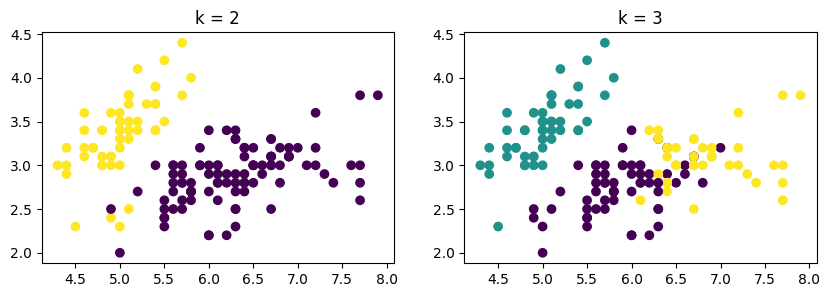

In [9]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.scatter(X['sepal length (cm)'], X['sepal width (cm)'], c = labels_2)
plt.title('k = 2');

plt.subplot(1, 2, 2)
plt.scatter(X['sepal length (cm)'], X['sepal width (cm)'], c = labels_3)
plt.title('k = 3');

plt.show()

З візуалізації видно, що при k = 3 більше точок знаходяться у неправильному кластері, ніж при k = 2.

Для n_clusters = 2 Середнє значення silhouette_score становить: 0.6810461692117462
Для n_clusters = 3 Середнє значення silhouette_score становить: 0.551191604619592


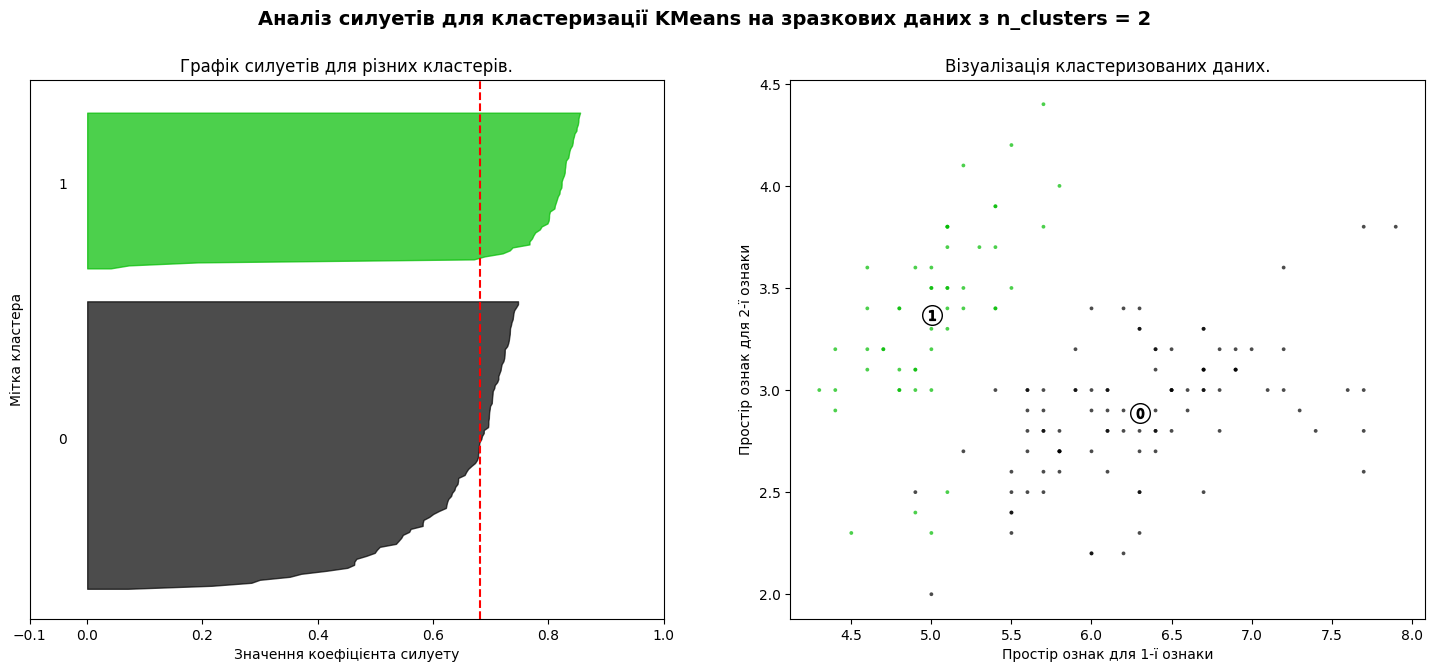

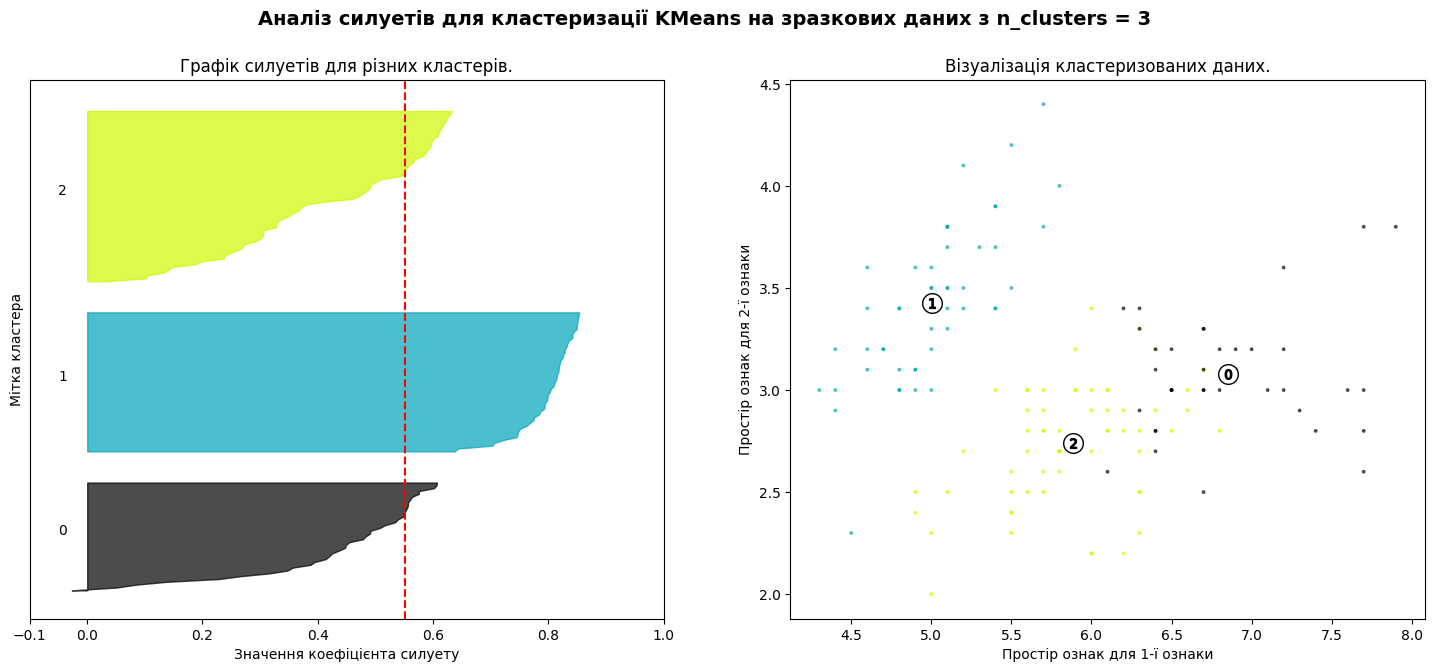

In [10]:
plot_silhoettes([2, 3], X, 'sepal length (cm)', 'sepal width (cm)')

З графіків силуету видно, що при k = 3 точки розподілені гірше (особливо в кластерах 0 та 2), ніж при k = 2.

# Завдання 2

In [6]:
df_students = pd.read_csv('Student_data.csv')
df_students.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


## Попередній аналіз

In [7]:
# розмір датасету

df_students.shape

(2392, 15)

In [8]:
# перевірка на пропущенні значення

df_students.isna().sum()

StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64

In [9]:
# Перевірка на наявність дублікатів

df_students.duplicated().sum()

0

Пропущених значень та дублікатів немає

In [10]:
# перевірка типів даних

df_students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB


Всі стовпці мають числові типи даних, що є правильно відповідно до їх контексту

In [11]:
df_students.describe()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,2196.500000,16.468645,0.510870,0.877508,1.746237,9.771992,14.541388,0.301421,2.122074,0.383361,0.303512,0.196906,0.157191,1.906186,2.983696
std,690.655244,1.123798,0.499986,1.028476,1.000411,5.652774,8.467417,0.458971,1.122813,0.486307,0.459870,0.397744,0.364057,0.915156,1.233908
min,1001.000000,15.000000,0.000000,0.000000,0.000000,0.001057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1598.750000,15.000000,0.000000,0.000000,1.000000,5.043079,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.174803,2.000000
50%,2196.500000,16.000000,1.000000,0.000000,2.000000,9.705363,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.893393,4.000000
75%,2794.250000,17.000000,1.000000,2.000000,2.000000,14.408410,22.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,2.622216,4.000000
max,3392.000000,18.000000,1.000000,3.000000,4.000000,19.978094,29.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000


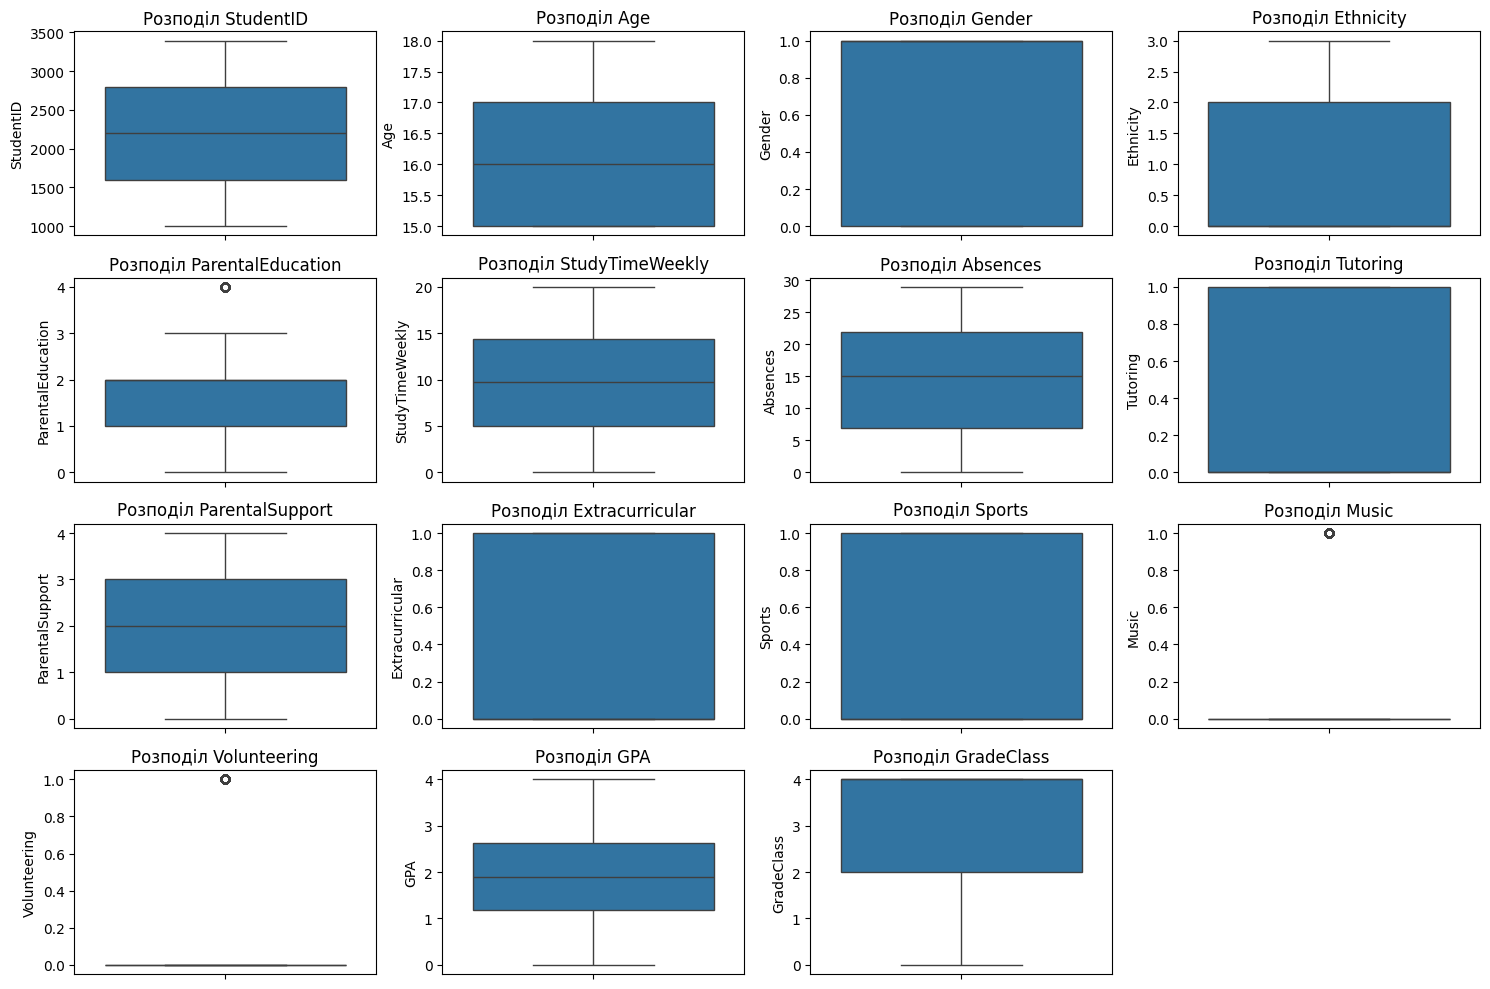

In [12]:
plt.figure(figsize=(15, 10))

for i, feature in enumerate(df_students):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(df_students[feature])
    
    plt.title(f'Розподіл {feature}')

plt.tight_layout()
plt.show()

1. StudentID: Дані розподілені рівномірно.
2. Age (Вік): Розподіл віку студентів коливається між 15 та 18 років, з медіаною приблизно 16.
3. Gender (Стать): Стать всіх студентів відповідає одному з двох значень (чоловічій або жіночій статі).
4. Ethnicity (Етнічність): Існує варіація між 0 і 3, що вказує на різноманітність етнічних груп.
5. ParentalEducation (Освіта батьків): Освіта батьків показує нормальний розподіл з медіаною приблизно на рівні 2, є один викид.
6. StudyTimeWeekly (Час на навчання щотижня): Час, витрачений на навчання щотижня, варіюється від 0 до 20 годин, з медіаною приблизно 10 годин.
7. Absences (Пропуски): Кількість пропусків має широкий розкид від 0 до 30 з медіаною на рівні 15.
8. Tutoring (Додаткові заняття): Розподіл варіюється від 0 до 1.
9. ParentalSupport (Підтримка батьків): Студенти мають різний рівень підтримки батьків, з медіаною близько 2.
10. Extracurricular (Позакласні заняття): Розподіл варіюється від 0 до 1.
11. Sports (Спорт): Розподіл варіюється від 0 до 1..
12. Music (Музика): Спостерігається одна значна аномалія (викид), але більшість студентів не займається музикою.
13. Volunteering (Волонтерство): Більшість студентів не беруть участі у волонтерстві, є один викид.
14. GPA (Середній бал): Середній бал варіюється від 0 до 4, медіана на рівні приблизно 2.
15. GradeClass (Клас навчання): Більшість студентів перебуває з другого по четвертий клас.

## Побудова та налаштування моделей

Буду використовувати моделі класифікації даних, оскільки прогнозується конкретний клас.

In [13]:
df_students.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [14]:
# Розділення даних на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(df_students.drop(columns = ['GradeClass']), 
                                                    df_students['GradeClass'], 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Я вважаю, що ID учня ніяк не впливає на визначення класу, тому надалі цей стовпець використовувати не буду
X_train.drop(['StudentID'], axis = 1, inplace = True)
X_test.drop(['StudentID'], axis = 1, inplace = True)

# Масштабування числових ознак
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

In [15]:
display(X_train_scaled.head(), y_train.head())

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA
0,1.000000,1.0,0.000000,1.00,0.907339,0.827586,1.0,0.00,1.0,1.0,0.0,0.0,0.349070
1,0.333333,1.0,1.000000,0.50,0.123306,0.655172,0.0,0.25,0.0,0.0,0.0,1.0,0.188688
2,0.666667,0.0,0.666667,0.75,0.172761,0.862069,0.0,0.00,0.0,0.0,0.0,0.0,0.034041
3,0.666667,1.0,0.000000,0.25,0.793076,0.862069,1.0,0.50,0.0,0.0,0.0,0.0,0.293048
4,0.333333,0.0,0.000000,0.00,0.051970,0.655172,1.0,0.50,0.0,0.0,1.0,0.0,0.436839


642     4.0
1752    4.0
1401    4.0
2032    4.0
990     4.0
Name: GradeClass, dtype: float64

### Логістична регресія

#### Базова модель

Training accuracy: 68.53%
F1 score Training: 0.64%
Test accuracy: 63.26%
F1 score Test: 0.57%


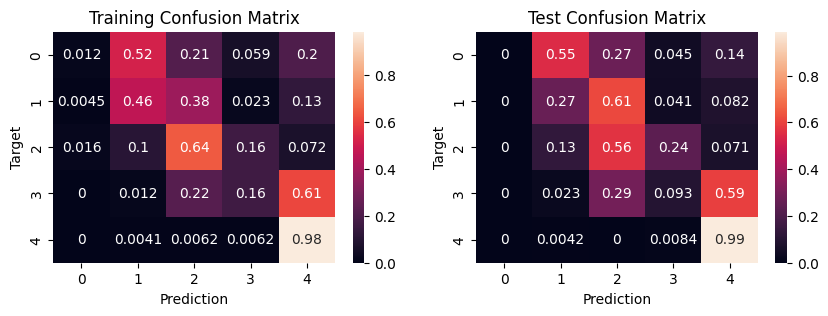

In [16]:
# Створення та тренування моделі
model_log = LogisticRegression(solver = 'liblinear')
model_log.fit(X_train_scaled, y_train)

# Прогнозування моделі
train_pred_logistic = model_log.predict(X_train_scaled)
test_pred_logistic  = model_log.predict(X_test_scaled)

# Оцінка моделі
predict_and_plot(y_train, y_test, train_pred_logistic, test_pred_logistic)

 - Модель показує дещо кращі результати на тренувальному наборі (68.53%) в порівнянні з тестовим набором (63.26%), що вказує на перенавчання.
 - F1-score, який є важливим показником, є досить низьким як на тренувальному, так і на тестовому наборах.
 - Треба покращувати модель.

#### Підбір гіперпараметрів

Найкращі параметри для логістичної регресії: {'C': 10, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}
Training accuracy: 81.13%
F1 score Training: 0.80%
Test accuracy: 74.32%
F1 score Test: 0.73%


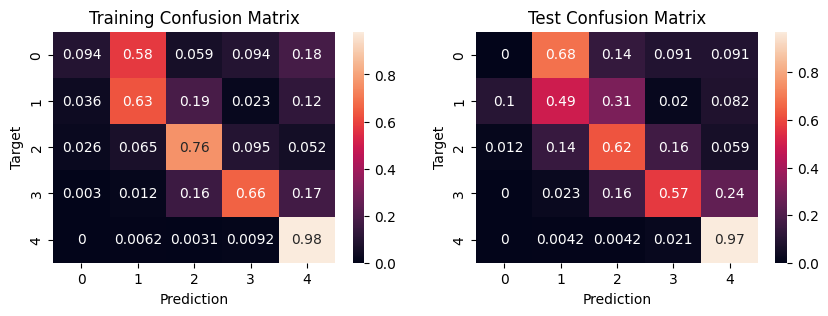

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    warnings.simplefilter("ignore", UserWarning)

    log_reg = LogisticRegression(max_iter = 1000)

    parameters = [
        {'solver': ['newton-cg', 'lbfgs', 'sag'], 'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
        {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
        {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}  # 'l1_ratio' тільки для elasticnet
    ]

    model_log_grid = GridSearchCV(estimator = log_reg, param_grid = parameters, scoring = 'accuracy', cv = 5, verbose = 0)

    model_log_grid.fit(X_train_scaled, y_train)

    log_best_model = model_log_grid.best_estimator_

    train_pred_log_grid = log_best_model.predict(X_train_scaled)
    test_pred_log_grid  = log_best_model.predict(X_test_scaled)

    print("Найкращі параметри для логістичної регресії:", model_log_grid.best_params_)

    predict_and_plot(y_train, y_test, train_pred_log_grid, test_pred_log_grid)

#### Висновки

1. Точність на тренувальному наборі зросла з 68.53% до 81.13%, що демонструє значне покращення у здатності моделі правильно класифікувати тренувальні дані.

2. Точність на тестовому наборі також значно зросла — з 63.26% до 74.32%, що свідчить про поліпшення загальної узагальнювальної здатності моделі на нових даних.

3. F1-score на тренувальному наборі збільшився з 0.64 до 0.80, що вказує на суттєве покращення балансу між precision і recall моделі на тренувальних даних.

4. F1-score на тестовому наборі покращився з 0.57 до 0.73, що підтверджує, що модель стала більш ефективною у класифікації нових даних. 

5. Оптимізація параметрів за допомогою elasticnet та налаштування коефіцієнта регуляризації C = 10 дозволила покращити результати, зменшивши вплив нерелевантних ознак та підвищивши стабільність моделі.

Таким чином, покращені параметри логістичної регресії призвели до значного підвищення точності та збалансованості моделі як на тренувальних, так і на тестових даних, що робить її більш надійною для практичного використання. Але модель ще можна покращувати.

### Random Forest

#### Базова модель

Training
              precision    recall  f1-score   support

         0.0     0.9394    0.3647    0.5254        85
         1.0     0.8257    0.8182    0.8219       220
         2.0     0.9191    0.9281    0.9236       306
         3.0     0.9154    0.8902    0.9026       328
         4.0     0.9265    0.9836    0.9542       974

    accuracy                         0.9122      1913
   macro avg     0.9052    0.7970    0.8255      1913
weighted avg     0.9124    0.9122    0.9062      1913


Test
              precision    recall  f1-score   support

         0.0     1.0000    0.1364    0.2400        22
         1.0     0.6885    0.8571    0.7636        49
         2.0     0.9125    0.8588    0.8848        85
         3.0     0.9048    0.8837    0.8941        86
         4.0     0.9323    0.9873    0.9590       237

    accuracy                         0.8935       479
   macro avg     0.8876    0.7447    0.7483       479
weighted avg     0.9020    0.8935    0.8812       479

Trainin

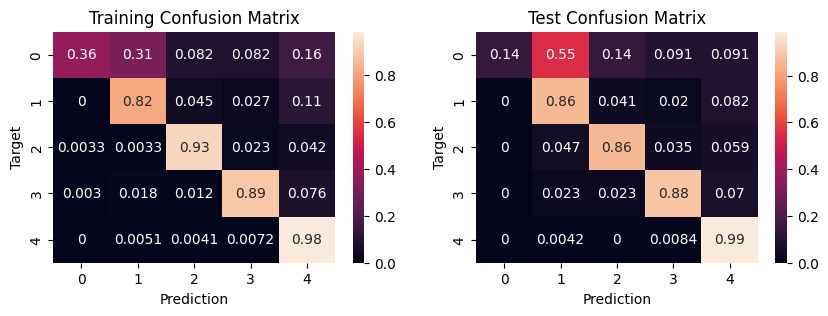

In [18]:
# Створення моделі
model_rnd_clf = RandomForestClassifier(n_estimators = 5,
                                       max_leaf_nodes = 16,
                                       n_jobs = -1,
                                       random_state = 42)

# Тренування моделі
model_rnd_clf.fit(X_train_scaled, y_train)

# Прогнозування моделі
train_pred_rnd_clf = model_rnd_clf.predict(X_train_scaled)
test_pred_rnd_clf  = model_rnd_clf.predict(X_test_scaled)

# Оцінка моделі
get_report(y_train, train_pred_rnd_clf, y_test, test_pred_rnd_clf)
predict_and_plot(y_train, y_test, train_pred_rnd_clf, test_pred_rnd_clf)

Модель демонструє хороші результати як на тренувальних, так і на тестових даних. Невелике зниження метрик на тестових даних може вказувати на незначне перенавчання, але модель все ще має добру узагальнюючу здатність.

#### Підбір гіперпараметрів

In [21]:
rf = RandomForestClassifier(random_state = 42)
params_rf = {
    'n_estimators': [1, 5, 10, 50, 100, 200],
    'max_leaf_nodes':[4, 8, 16, 32]
}

model_rnd_clf_grid = GridSearchCV(rf, params_rf, cv = 5)
model_rnd_clf_grid.fit(X_train_scaled, y_train)

rf_best_model = model_rnd_clf_grid.best_estimator_

train_pred_rnd_clf_grid = rf_best_model.predict(X_train_scaled)
test_pred_rnd_clf_grid  = rf_best_model.predict(X_test_scaled)

print("Найкращі параметри для Random forest:", model_rnd_clf_grid.best_params_)

get_report(y_train, train_pred_rnd_clf_grid, y_test, test_pred_rnd_clf_grid)

Найкращі параметри для Random forest: {'max_leaf_nodes': 32, 'n_estimators': 50}
Training
              precision    recall  f1-score   support

         0.0     0.9643    0.6353    0.7660        85
         1.0     0.9350    0.8500    0.8905       220
         2.0     0.9344    0.9314    0.9329       306
         3.0     0.9169    0.9085    0.9127       328
         4.0     0.9318    0.9825    0.9565       974

    accuracy                         0.9310      1913
   macro avg     0.9365    0.8615    0.8917      1913
weighted avg     0.9315    0.9310    0.9292      1913


Test
              precision    recall  f1-score   support

         0.0     0.8750    0.3182    0.4667        22
         1.0     0.7500    0.8571    0.8000        49
         2.0     0.9250    0.8706    0.8970        85
         3.0     0.8953    0.8953    0.8953        86
         4.0     0.9398    0.9873    0.9630       237

    accuracy                         0.9061       479
   macro avg     0.8770    0.7857  

#### Висновки

1. Точність на тренувальному наборі зросла з 91.22% до 93.10%.

2. Точність на тестовому наборі також покращилася з 89.35% до 90.61%, що є позитивним показником. 

3. F1-score на тестовому наборі зріс з 0.88 до 0.90, що свідчить про покращення як у точності , так і у відсотку правильних прогнозів серед усіх позитивних прикладів.

4. Для класу 0.0, значення точності на тесті збільшилося, але відсоток recall залишився низьким (0.3182), що свідчить про те, що модель все ще має труднощі з коректною класифікацією цього класу. Однак, для інших класів (особливо для класу 4.0), precision і recall залишаються на високому рівні.

5. Загальний баланс між precision і recall покращився, що робить модель більш надійною і стабільною як на тренувальному, так і на тестовому наборах даних.

Таким чином, оптимізація параметрів (зокрема, обмеження кількості листків та кількості дерев) привела до покращення як тренувальної, так і тестової точності, що позитивно впливає на загальну продуктивність моделі.

### Decision Tree

#### Базова модель

Training
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000        85
         1.0     1.0000    1.0000    1.0000       220
         2.0     1.0000    1.0000    1.0000       306
         3.0     1.0000    1.0000    1.0000       328
         4.0     1.0000    1.0000    1.0000       974

    accuracy                         1.0000      1913
   macro avg     1.0000    1.0000    1.0000      1913
weighted avg     1.0000    1.0000    1.0000      1913


Test
              precision    recall  f1-score   support

         0.0     0.6190    0.5909    0.6047        22
         1.0     0.6406    0.8367    0.7257        49
         2.0     0.8800    0.7765    0.8250        85
         3.0     0.8193    0.7907    0.8047        86
         4.0     0.8941    0.8903    0.8922       237

    accuracy                         0.8330       479
   macro avg     0.7706    0.7770    0.7704       479
weighted avg     0.8396    0.8330    0.8343       479

Trainin

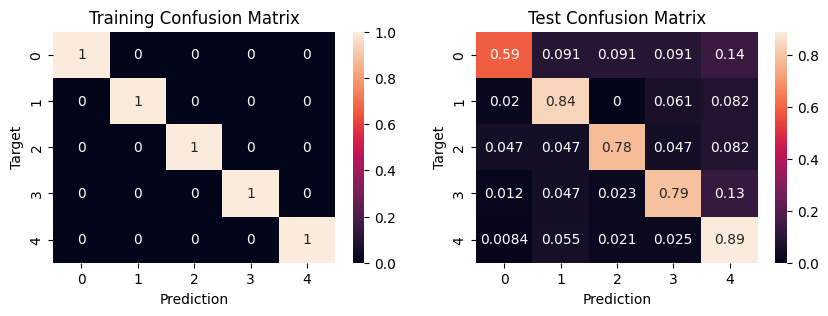

In [22]:
# Створення моделі
model_dt = DecisionTreeClassifier(random_state = 42)

# Тренування моделі
model_dt.fit(X_train_scaled, y_train)

# Прогнозування моделі
train_pred_dt = model_dt.predict(X_train_scaled)
test_pred_dt  = model_dt.predict(X_test_scaled)

# Оцінка моделі
get_report(y_train, train_pred_dt, y_test, test_pred_dt)
predict_and_plot(y_train, y_test, train_pred_dt, test_pred_dt)

Дана модель сильно перенавчена.

#### Підбір гіперпараметрів

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Найкращі параметри для Decision tree: {'ccp_alpha': 0.01, 'criterion': 'gini', 'max_depth': 5, 'max_features': None}
Training
              precision    recall  f1-score   support

         0.0     0.9344    0.6706    0.7808        85
         1.0     0.9538    0.8455    0.8964       220
         2.0     0.9344    0.9314    0.9329       306
         3.0     0.9141    0.9085    0.9113       328
         4.0     0.9318    0.9815    0.9560       974

    accuracy                         0.9315      1913
   macro avg     0.9337    0.8675    0.8955      1913
weighted avg     0.9318    0.9315    0.9300      1913


Test
              precision    recall  f1-score   support

         0.0     0.8750    0.6364    0.7368        22
         1.0     0.8776    0.8776    0.8776        49
         2.0     0.9367    0.8706    0.9024        85
         3.0     0.8953    0.8953    0.8953        86
         4.0     0.9398    0.9873    0.9630   

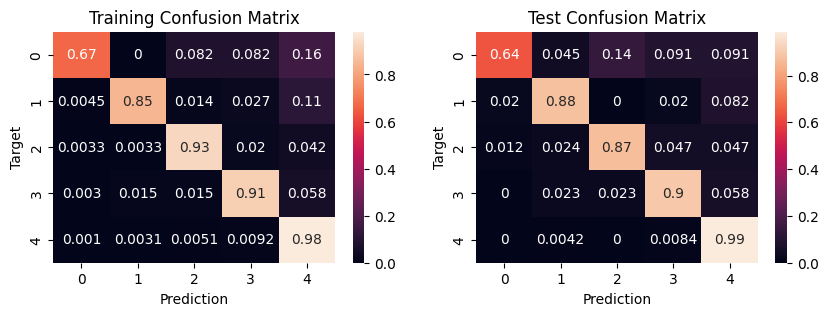

In [23]:
dt = DecisionTreeClassifier(random_state = 42)

param_grid = {'max_features': [None, 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' : ['gini', 'entropy']
             }

model_dt_grid = GridSearchCV(estimator = dt, param_grid = param_grid, cv = 5, verbose = True)
model_dt_grid.fit(X_train_scaled, y_train)

dt_best_model = model_dt_grid.best_estimator_

train_pred_dt_grid = dt_best_model.predict(X_train_scaled)
test_pred_dt_grid  = dt_best_model.predict(X_test_scaled)

print("Найкращі параметри для Decision tree:", model_dt_grid.best_params_)

get_report(y_train, train_pred_dt_grid, y_test, test_pred_dt_grid)
predict_and_plot(y_train, y_test, train_pred_dt_grid, test_pred_dt_grid)

#### Висновки

1. Тренувальна точність знизилася з 100% до 93.15% після застосування регуляризації. Це свідчить про усунення перенавчання.

2. Точність на тестовому наборі значно зросла з 83.30% до 92.28%, що вказує на те, що модель тепер краще узагальнює нові дані, не будучи перенавченою.

3. F1-score на тренувальних даних знизився з 1.00 до 0.93, що є очікуваним через зменшення складності моделі, однак це незначне зниження компенсується покращенням на тестових даних.

4. F1-score на тестових даних зріс з 0.83 до 0.92, що свідчить про кращий баланс між precision і recall для кожного класу на тестовому наборі.

5. Для класу 0.0 покращення значні, precision зросла з 0.6190 до 0.8750, а recall з 0.5909 до 0.6364, що свідчить про кращу класифікацію цього класу після оптимізації.

6. Оптимізація параметрів, зокрема використання ccp_alpha = 0.01 для обрізання (pruning) та обмеження max_depth = 5, дозволила створити менш складне дерево з кращою здатністю узагальнення.

Загалом, модель стала значно краще працювати на тестових даних, що демонструє її здатність узагальнювати нові дані після зниження перенавчення, що було проблемою у базовій моделі.

## Загальні висновки щодо побудованих моделей

In [25]:
train_accuracy_log      = accuracy_score(y_train, train_pred_logistic)
train_accuracy_log_grid = accuracy_score(y_train, train_pred_log_grid)
train_accuracy_rf       = accuracy_score(y_train, train_pred_rnd_clf)
train_accuracy_rf_grid  = accuracy_score(y_train, train_pred_rnd_clf_grid)
train_accuracy_dt       = accuracy_score(y_train, train_pred_dt)
train_accuracy_dt_grid  = accuracy_score(y_train, train_pred_dt_grid)

train_f1_log      = f1_score(y_train, train_pred_logistic, average = 'weighted')
train_f1_log_grid = f1_score(y_train, train_pred_log_grid, average = 'weighted')
train_f1_rf       = f1_score(y_train, train_pred_rnd_clf, average = 'weighted')
train_f1_rf_grid  = f1_score(y_train, train_pred_rnd_clf_grid, average = 'weighted')
train_f1_dt       = f1_score(y_train, train_pred_dt, average = 'weighted')
train_f1_dt_grid  = f1_score(y_train, train_pred_dt_grid, average = 'weighted')

test_accuracy_log      = accuracy_score(y_test, test_pred_logistic)
test_accuracy_log_grid = accuracy_score(y_test, test_pred_log_grid)
test_accuracy_rf       = accuracy_score(y_test, test_pred_rnd_clf)
test_accuracy_rf_grid  = accuracy_score(y_test, test_pred_rnd_clf_grid)
test_accuracy_dt       = accuracy_score(y_test, test_pred_dt)
test_accuracy_dt_grid  = accuracy_score(y_test, test_pred_dt_grid)

test_f1_log      = f1_score(y_test, test_pred_logistic, average = 'weighted')
test_f1_log_grid = f1_score(y_test, test_pred_log_grid, average = 'weighted')
test_f1_rf       = f1_score(y_test, test_pred_rnd_clf, average = 'weighted')
test_f1_rf_grid  = f1_score(y_test, test_pred_rnd_clf_grid, average = 'weighted')
test_f1_dt       = f1_score(y_test, test_pred_dt, average = 'weighted')
test_f1_dt_grid  = f1_score(y_test, test_pred_dt_grid, average = 'weighted')

In [30]:
results = pd.DataFrame({
    'Model' : ['Logistic Regression', 'Logistic Regression GridSearch', 'Random Forest', 'Random Forest GridSearch', 'Decision Tree', 'Decision Tree GridSearch'],
    'Train Accuracy' : [train_accuracy_log, train_accuracy_log_grid, train_accuracy_rf, train_accuracy_rf_grid, train_accuracy_dt, train_accuracy_dt_grid],
    'Test Accuracy' : [test_accuracy_log, test_accuracy_log_grid, test_accuracy_rf, test_accuracy_rf_grid, test_accuracy_dt, test_accuracy_dt_grid],
    'Train F1 Score' : [train_f1_log, train_f1_log_grid, train_f1_rf, train_f1_rf_grid, train_f1_dt, train_f1_dt_grid],
    'Test F1 score' : [test_f1_log, test_f1_log_grid, test_f1_rf, test_f1_rf_grid, test_f1_dt, test_f1_dt_grid]
})

display(results)

,Model,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 score
0,Logistic Regression,0.685311,0.632568,0.635509,0.574993
1,Logistic Regression GridSearch,0.811291,0.743215,0.796862,0.725853
2,Random Forest,0.912180,0.893528,0.906186,0.881193
3,Random Forest GridSearch,0.930998,0.906054,0.929168,0.899648
4,Decision Tree,1.000000,0.832985,1.000000,0.834317
5,Decision Tree GridSearch,0.931521,0.922756,0.930003,0.920960


Модель Decision Tree після GridSearch демонструє найкращий баланс між точністю на тестових даних і F1-score, тому вона є найбільш підходящою для використання в цьому випадку.

## Кластеризація 

In [98]:
# розділення даних на два набори X та y

X = df_students.drop(columns = ['GradeClass', 'StudentID'])
y = df_students['GradeClass'].astype('int64')

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
y_scaled = y

Silhouette Coefficient for the data Dataset Clusters for k = 2: 0.098
Silhouette Coefficient for the data Dataset Clusters for k = 3: 0.135
Silhouette Coefficient for the data Dataset Clusters for k = 4: 0.112
Silhouette Coefficient for the data Dataset Clusters for k = 5: 0.113
Silhouette Coefficient for the data Dataset Clusters for k = 6: 0.140
Silhouette Coefficient for the data Dataset Clusters for k = 7: 0.137
Silhouette Coefficient for the data Dataset Clusters for k = 8: 0.122
Silhouette Coefficient for the data Dataset Clusters for k = 9: 0.128
Silhouette Coefficient for the data Dataset Clusters for k = 10: 0.138


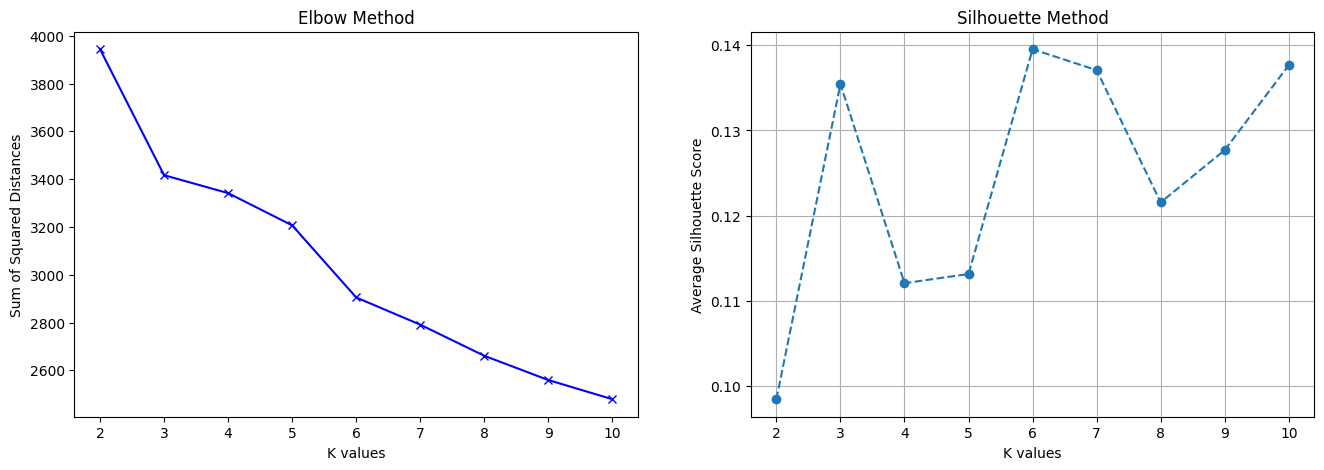

In [88]:
# визначення оптимальної кількості кластерів за допомогою методу ліктя та коефіцієнта середнього силуета

K = range(2, 11)
sum_of_squared_distances = []
silhouette_scores        = []

for k in K:    
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 'auto', random_state = 170)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)

    sum_of_squared_distances.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_avg)

    print(f'Silhouette Coefficient for the data Dataset Clusters for k = {k}: {silhouette_avg:.3f}')

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('K values')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker = 'o', linestyle = '--')
plt.title('Silhouette Method')
plt.xlabel('K values')
plt.ylabel('Average Silhouette Score')
plt.grid(True)

plt.show()

 - Виходячи із результатів, отриманих за допомогою методу ліктя, найкращою кількістю кластерів може бути 3 або 6.
 - Метод силуетів найвищі значення показав у точках, де k = 6, k = 7, k = 10.
 - Але у вхідному датасеті учні були розподілені між п'ятьма класами (0, 1, 2, 3, 4, 5), тобто k = 5. Тобто, виходячи із методу силуетів, найблище до 5 є 6, тому далі буду працювати із k = 6.

In [89]:
kmeans_6 = KMeans(n_clusters = 6, init = 'k-means++', n_init = 'auto', random_state = 170)
kmeans_6.fit(X_scaled)
labels_6 = kmeans_6.predict(X_scaled)

In [125]:
# Пониження розмірності за допомогою t-SNE
tsne    = TSNE(n_components = 2, random_state = 0)
tsne_df = pd.DataFrame(tsne.fit_transform(X_scaled), columns = ['x', 'y'])

# Додавання міток кластерів
tsne_df['labels'] = labels_6
tsne_df = pd.concat([tsne_df, X_scaled], axis=1)

# Побудова інтерактивного 2D-графіку
fig = px.scatter(
    tsne_df,
    x = 'x',
    y = 'y',
    color = 'labels',
    title = '2D Scatter Plot of Dataset with t-SNE (k = 6)'
)

# Оновлення макету та відображення графіку
fig.update_layout(title_x = 0.5)
fig.show()

Додаю зображення, оскільки 3д візуалізація може не відобразитись 

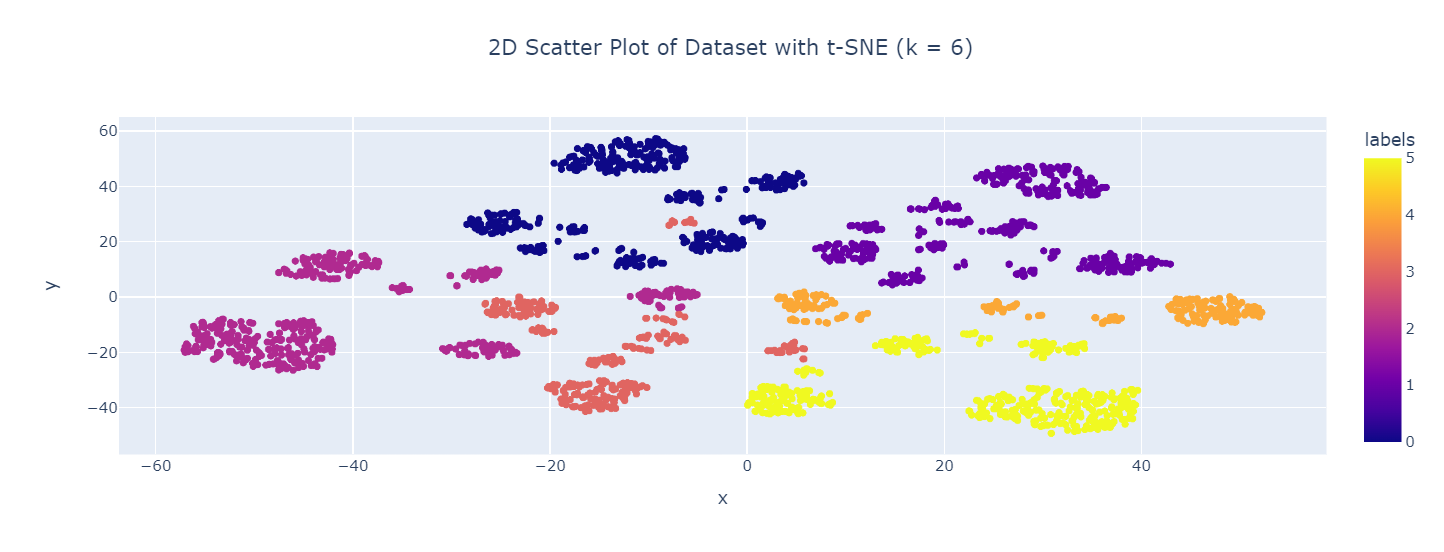

In [128]:
# Пониження розмірності за допомогою t-SNE
tsne    = TSNE(n_components = 2, random_state = 0)
tsne_df = pd.DataFrame(tsne.fit_transform(X_scaled), columns = ['x', 'y'])

# Додавання міток кластерів
tsne_df['labels'] = y
tsne_df = pd.concat([tsne_df, X_scaled], axis=1)

# Побудова інтерактивного 2D-графіку
fig = px.scatter(
    tsne_df,
    x = 'x',
    y = 'y',
    color = 'labels',
    title = '2D Scatter Plot of Dataset with t-SNE (k = 5)'
)

# Оновлення макету та відображення графіку
fig.update_layout(title_x = 0.5)
fig.show()

Додаю зображення, оскільки 3д візуалізація може не відобразитись 

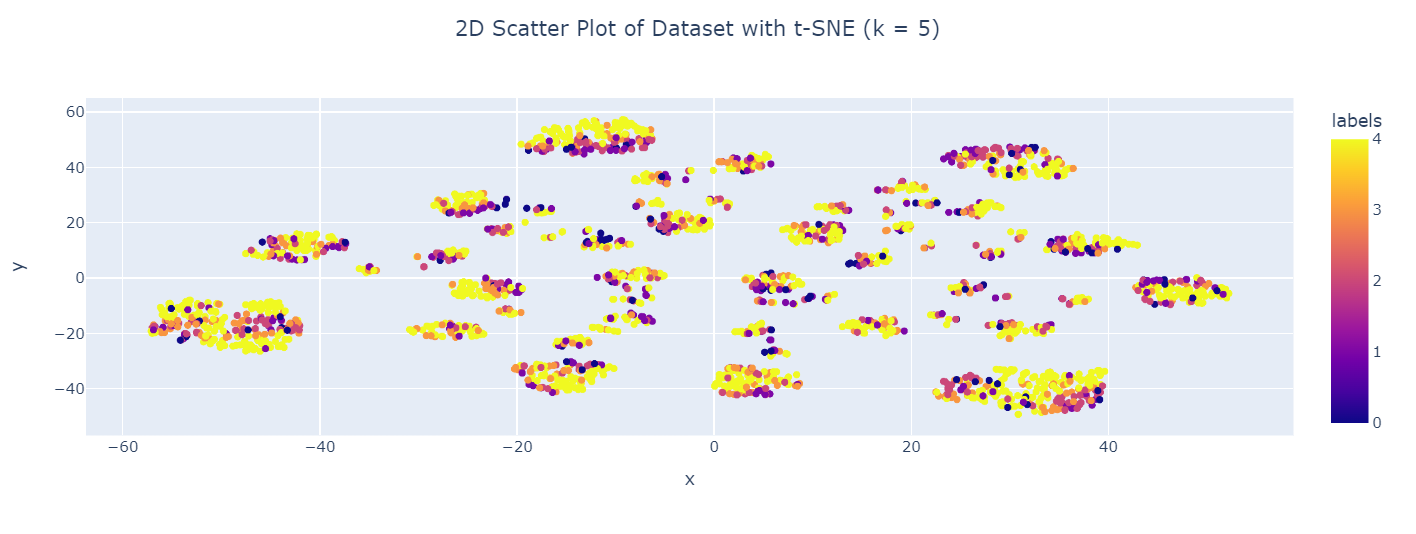

Отже, бачимо що прикількості кластерів 6 розподілення відбувається краще, ніж при 5.